In [1]:
import numpy as np

import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.datasets import mnist
from keras.utils import plot_model
import keras.backend as K

import matplotlib.pyplot as plt
from IPython.display import Image

Using TensorFlow backend.


In [2]:
encoding_dimension = 2

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
def reshape_images(images):
    return images.reshape((len(images), np.prod(images.shape[1:])))

def normalize(images):
    return images / 255

In [5]:
x_train = reshape_images(normalize(x_train))
x_test = reshape_images(normalize(x_test))
print(f'[{x_train.shape}, {x_test.shape}]', '#[x_train.shape, x_test.shape]')

[(60000, 784), (10000, 784)] #[x_train.shape, x_test.shape]


In [6]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
def build_models(latent_dim, intermediate_dim, input_shape, use_mse=False):
    # Encoder
    encoder_input = Input(shape=input_shape, name='encoder_input')
    intermediate = Dense(
        intermediate_dim, activation='relu', 
        name='intermediate'
    )(encoder_input)
    z_mean = Dense(latent_dim, name='z_mean')(intermediate)
    z_log_var = Dense(latent_dim, name='z_log_var')(intermediate)
    z = Lambda(
        sampling, output_shape=(latent_dim,), name='z'
    )([z_mean, z_log_var])
    
    encoder = Model(
        encoder_input, [z_mean, z_log_var, z], name='encoder'
    )
    
    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    decoder_intermediate = Dense(
        intermediate_dim, activation='relu',
        name='decoder_intermediate'
    )(latent_inputs)
    outputs = Dense(
        input_shape[0], activation='sigmoid',
        name='outputs'
    )(decoder_intermediate)
    
    decoder = Model(latent_inputs, outputs, name='decoder')
    
    # VAE
    layer_out = decoder(encoder(encoder_input)[2])
    vae = Model(encoder_input, layer_out, name='vae')
    
    # Attach a loss function
    image_shape = input_shape[0]

    # Get the reconstruction loss
    if use_mse:
        reconstruction_loss = mse(encoder_input, layer_out)
    else:
        reconstruction_loss = binary_crossentropy(encoder_input, layer_out)
    reconstruction_loss *= image_shape
    print(reconstruction_loss)

    # Create the KL Divergence
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    return vae, encoder, decoder

In [8]:
vae, encoder, decoder = build_models(
    latent_dim=encoding_dimension, intermediate_dim=512,
    input_shape=(784,), use_mse=True
)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("mul:0", shape=(?,), dtype=float32)


In [9]:
vae.compile(optimizer='adam')

In [10]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


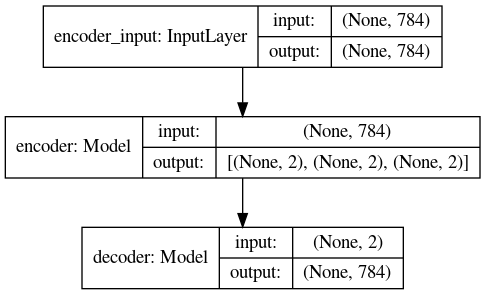

In [11]:
plot_model(vae, show_shapes=True, show_layer_names=True, to_file='vae_model.png')
Image(retina=True, filename='vae_model.png')

In [12]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
intermediate (Dense)            (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        intermediate[0][0]               
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        intermediate[0][0]               
__________________________________________________________________________________________________
z (Lambda)

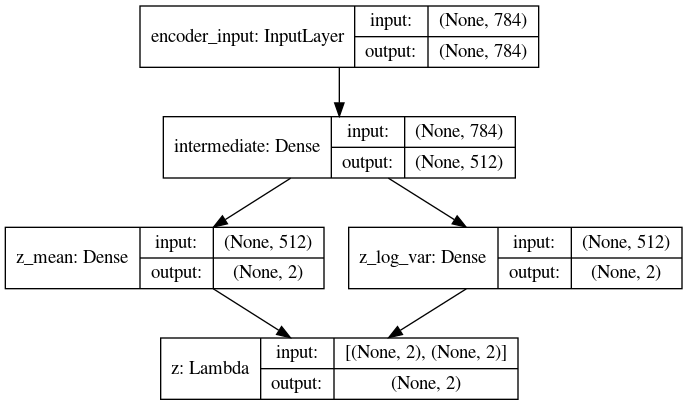

In [13]:
plot_model(encoder, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [14]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
decoder_intermediate (Dense) (None, 512)               1536      
_________________________________________________________________
outputs (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


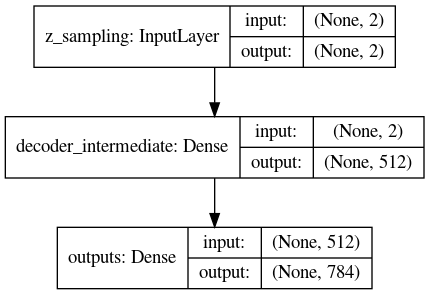

In [15]:
plot_model(decoder, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [16]:
history = vae.fit(
  x_train,
  epochs=300, batch_size=256,
  shuffle=True, validation_data=(x_test, None)
)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 2s 34us/step - loss: 59.2405 - val_loss: 46.8804
Epoch 2/300
60000/60000 [==============================] - 1s 16us/step - loss: 45.0730 - val_loss: 43.7093
Epoch 3/300
60000/60000 [==============================] - 1s 17us/step - loss: 43.4515 - val_loss: 42.8164
Epoch 4/300
60000/60000 [==============================] - 1s 16us/step - loss: 42.7265 - val_loss: 42.2591
Epoch 5/300
60000/60000 [==============================] - 1s 16us/step - loss: 42.1407 - val_loss: 41.7571
Epoch 6/300
60000/60000 [==============================] - 1s 16us/step - loss: 41.6736 - val_loss: 41.2551
Epoch 7/300
60000/60000 [==============================] - 1s 16us/step - loss: 41.2466 - val_loss: 40.9732
Epoch 8/300
60000/60000 [==============================] - 1s 16us/step - loss: 40.9326 - val_loss: 40.7105
Epoch 9/300
60000/60000 [=============

60000/60000 [==============================] - 1s 16us/step - loss: 36.2825 - val_loss: 37.3475
Epoch 74/300
60000/60000 [==============================] - 1s 16us/step - loss: 36.2782 - val_loss: 37.3614
Epoch 75/300
60000/60000 [==============================] - 1s 16us/step - loss: 36.2200 - val_loss: 37.3299
Epoch 76/300
60000/60000 [==============================] - 1s 16us/step - loss: 36.2273 - val_loss: 37.3876
Epoch 77/300
60000/60000 [==============================] - 1s 16us/step - loss: 36.1975 - val_loss: 37.2255
Epoch 78/300
60000/60000 [==============================] - 1s 16us/step - loss: 36.1544 - val_loss: 37.3601
Epoch 79/300
60000/60000 [==============================] - 1s 17us/step - loss: 36.1612 - val_loss: 37.3176
Epoch 80/300
60000/60000 [==============================] - 1s 17us/step - loss: 36.1575 - val_loss: 37.3053
Epoch 81/300
60000/60000 [==============================] - 1s 17us/step - loss: 36.1267 - val_loss: 37.2308
Epoch 82/300
60000/60000 [======

Epoch 148/300
60000/60000 [==============================] - 1s 15us/step - loss: 35.3374 - val_loss: 37.1415
Epoch 149/300
60000/60000 [==============================] - 1s 16us/step - loss: 35.3077 - val_loss: 37.0032
Epoch 150/300
60000/60000 [==============================] - 1s 16us/step - loss: 35.3429 - val_loss: 36.9570
Epoch 151/300
60000/60000 [==============================] - 1s 16us/step - loss: 35.3254 - val_loss: 37.0711
Epoch 152/300
60000/60000 [==============================] - 1s 16us/step - loss: 35.3046 - val_loss: 37.0401
Epoch 153/300
60000/60000 [==============================] - 1s 16us/step - loss: 35.3078 - val_loss: 37.0454
Epoch 154/300
60000/60000 [==============================] - 1s 16us/step - loss: 35.2795 - val_loss: 37.0825
Epoch 155/300
60000/60000 [==============================] - 1s 17us/step - loss: 35.2908 - val_loss: 36.9816
Epoch 156/300
60000/60000 [==============================] - 1s 16us/step - loss: 35.2740 - val_loss: 37.0142
Epoch 157/

60000/60000 [==============================] - 1s 16us/step - loss: 34.8709 - val_loss: 36.9474
Epoch 223/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.8724 - val_loss: 37.0294
Epoch 224/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.8523 - val_loss: 37.0416
Epoch 225/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.8738 - val_loss: 37.0220
Epoch 226/300
60000/60000 [==============================] - 1s 17us/step - loss: 34.8606 - val_loss: 36.9609
Epoch 227/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.8460 - val_loss: 37.0906
Epoch 228/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.8607 - val_loss: 37.0052
Epoch 229/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.8486 - val_loss: 37.0055
Epoch 230/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.8274 - val_loss: 37.1147
Epoch 231/300
60000/6000

60000/60000 [==============================] - 1s 16us/step - loss: 34.5876 - val_loss: 37.1100
Epoch 297/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.5520 - val_loss: 37.0741
Epoch 298/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.5671 - val_loss: 37.0988
Epoch 299/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.5559 - val_loss: 37.0905
Epoch 300/300
60000/60000 [==============================] - 1s 16us/step - loss: 34.5694 - val_loss: 37.0842


In [17]:
import os
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

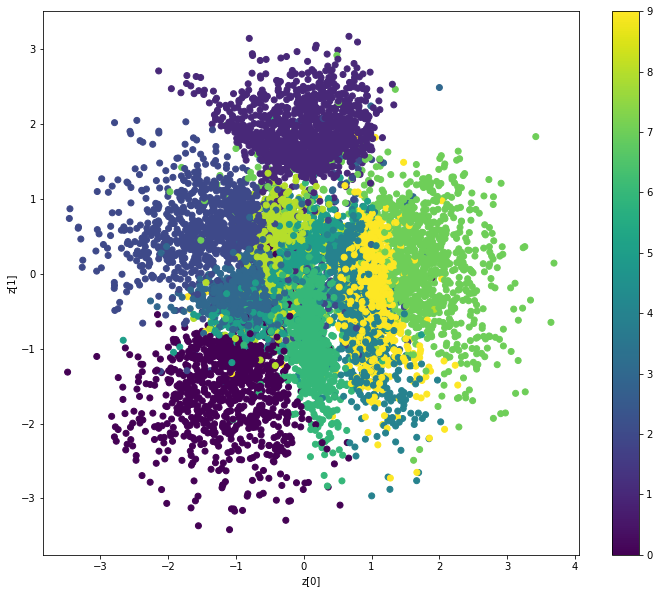

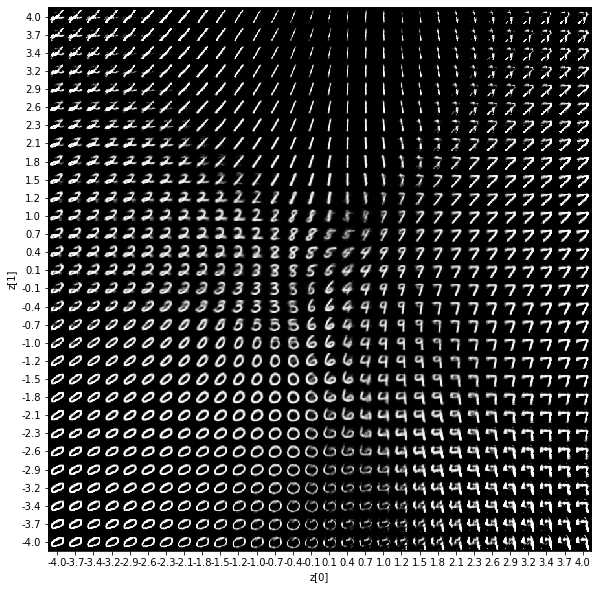

In [18]:
plot_results(
    models=(encoder, decoder),
    data=(x_test, y_test)
)